In [1]:
import sys
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, IntSlider

import numpy as np
import pandas as pd
import sqlite3
import torch

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [4]:
connection = sqlite3.connect("../../exp091024_100trials_init.db")
cursor = connection.cursor()

In [5]:
env_table = pd.read_sql("SELECT * FROM environments;", connection, index_col="env_id")
run_table = pd.read_sql("SELECT * FROM tunings;", connection, index_col="idx")

In [6]:
WL_COLUMNS = ['empty_reads', 'non_empty_reads', 'range_queries', 'writes']
SYS_COLUMNS = ['entry_size', 'selectivity', 'entries_per_page', 'num_elmement', 'bits_per_elem_max', 'read_write_asym']

In [7]:
env_table.head(10)

,empty_reads,non_empty_reads,range_queries,writes,entry_size,selectivity,entries_per_page,num_elmement,bits_per_elem_max,read_write_asym
env_id,,,,,,,,,,
1,0.25,0.25,0.25,0.25,8192,4.000000e-07,4,1000000000,10.0,1.0
2,0.97,0.01,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
3,0.01,0.97,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
4,0.01,0.01,0.97,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
5,0.01,0.01,0.01,0.97,8192,4.000000e-07,4,1000000000,10.0,1.0
6,0.49,0.49,0.01,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
7,0.49,0.01,0.49,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0
8,0.49,0.01,0.01,0.49,8192,4.000000e-07,4,1000000000,10.0,1.0
9,0.01,0.49,0.49,0.01,8192,4.000000e-07,4,1000000000,10.0,1.0


In [8]:
run_table.head(10)

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
idx,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,6.265555,21,7.0,9.0,7.0,4.0,9.0,...,6.0,9.0,7.0,15.0,18.0,12.0,25.0,11.0,25.0,30.895911
2,1,0,1,2.782982,9,27.0,16.0,28.0,22.0,24.0,...,24.0,20.0,26.0,29.0,8.0,25.0,4.0,16.0,11.0,47.651350
3,1,0,2,4.991060,8,14.0,4.0,14.0,27.0,2.0,...,17.0,24.0,10.0,16.0,9.0,21.0,13.0,25.0,19.0,38.707605
4,1,0,3,8.472546,26,20.0,25.0,22.0,8.0,17.0,...,13.0,6.0,17.0,1.0,28.0,1.0,19.0,1.0,3.0,40.512626
5,1,0,4,9.318712,16,9.0,20.0,26.0,12.0,19.0,...,11.0,15.0,15.0,21.0,13.0,29.0,11.0,6.0,16.0,40.664671
6,1,0,5,3.624246,14,17.0,13.0,3.0,23.0,5.0,...,22.0,18.0,19.0,6.0,23.0,9.0,17.0,28.0,6.0,34.075400
7,1,0,6,1.382188,4,2.0,29.0,17.0,18.0,26.0,...,27.0,29.0,3.0,9.0,22.0,6.0,27.0,20.0,28.0,57.875868
8,1,0,7,7.075568,29,24.0,7.0,10.0,7.0,11.0,...,1.0,4.0,23.0,23.0,3.0,18.0,5.0,14.0,8.0,34.566472
9,1,0,8,7.153934,15,12.0,27.0,16.0,29.0,21.0,...,23.0,7.0,12.0,20.0,14.0,2.0,7.0,8.0,5.0,39.365937


In [9]:
run_table.query("env_id == 5")

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
idx,,,,,,,,,,,,,,,,,,,,,
40001,5,0,0,2.774060,27,25.0,23.0,17.0,27.0,14.0,...,29.0,26.0,9.0,6.0,3.0,17.0,12.0,5.0,23.0,2.685708
40002,5,0,1,9.880333,15,5.0,14.0,6.0,13.0,24.0,...,13.0,11.0,28.0,20.0,27.0,9.0,23.0,17.0,4.0,4.181861
40003,5,0,2,7.014973,5,17.0,19.0,26.0,5.0,7.0,...,5.0,6.0,6.0,23.0,16.0,5.0,20.0,25.0,18.0,3.411221
40004,5,0,3,4.386871,18,12.0,3.0,11.0,20.0,17.0,...,21.0,21.0,17.0,9.0,14.0,27.0,2.0,13.0,14.0,3.764808
40005,5,0,4,3.732901,26,21.0,9.0,2.0,16.0,20.0,...,18.0,28.0,2.0,28.0,21.0,15.0,15.0,9.0,20.0,3.430815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,5,99,95,2.605147,22,19.0,19.0,9.0,9.0,9.0,...,2.0,10.0,1.0,12.0,17.0,7.0,9.0,7.0,4.0,2.700357
49997,5,99,96,2.384335,22,25.0,23.0,13.0,9.0,9.0,...,2.0,7.0,5.0,13.0,13.0,8.0,10.0,9.0,15.0,2.674793
49998,5,99,97,2.686984,22,27.0,23.0,14.0,7.0,9.0,...,2.0,5.0,1.0,11.0,19.0,8.0,6.0,8.0,11.0,2.679147


In [10]:
run_table.describe()

,env_id,trial,round,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.00000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,8.000000,49.500000,49.500000,5.401484,19.03822,9.672360,9.587520,8.822193,14.480660,15.112667,...,15.129100,15.041253,14.987393,14.823920,14.937180,15.043580,14.911087,15.152133,14.938573,32.404782
std,4.320508,28.866166,28.866166,2.503525,7.76288,8.607912,8.582069,8.081079,8.666405,8.467669,...,8.393058,8.358482,8.382305,8.383023,8.449522,8.417272,8.408668,8.372308,8.394189,34.939821
min,1.000000,0.000000,0.000000,1.000006,2.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.161711
25%,4.000000,24.750000,24.750000,3.243171,13.00000,2.000000,2.000000,2.000000,7.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2.671156
50%,8.000000,49.500000,49.500000,5.612655,19.00000,7.000000,6.000000,6.000000,14.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,29.857639
75%,12.000000,74.250000,74.250000,7.539447,26.00000,16.000000,16.000000,14.000000,22.000000,22.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,51.645631
max,15.000000,99.000000,99.000000,9.899967,30.00000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,362.581852


# Load in LTune Model

In [11]:
path = '/scratchNVMe/ndhuynh/other_data/models/ltune/klsm_0303PM_090524/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
cf = EndureCost(config)
design_type = getattr(Policy, config["lsm"]["design"])
bounds = LSMBounds(**config["lsm"]["bounds"])

In [12]:
model = LTuneModelBuilder(
    size_ratio_range=bounds.size_ratio_range,
    max_levels=bounds.max_considered_levels,
    **config["ltune"]["model"],
).build_model(design_type)
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_14.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

<All keys matched successfully>

In [13]:
ltune_util = LTuneEvalUtil(config, model, design_type)

## Example of how to evaluate ltune

In [14]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)

# Plotting Experiments


1. Train a LTune model
2. Start with a clean BO model
3. Pick a workload, w, that both models have not seen
4. Train BO model, while capturing the designs at each round (round <- (suggest, cost, register))
5. Plot performance of each round, and the performance of a single LTune suggestion for w

## Parameters

Change run_id to look at a different environment setup

In [15]:
def add_learned_tunings(con: sqlite3.Connection) -> None:
    cursor = con.cursor()
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS learned_tunings (
            env_id INTEGER PRIMARY KEY AUTOINCREMENT,
            bits_per_elem REAL,
            size_ratio INTEGER,
            kap0 REAL, kap1 REAL, kap2 REAL, kap3 REAL, kap4 REAL,
            kap5 REAL, kap6 REAL, kap7 REAL, kap8 REAL, kap9 REAL,
            kap10 REAL, kap11 REAL, kap12 REAL, kap13 REAL, kap14 REAL,
            kap15 REAL, kap16 REAL, kap17 REAL, kap18 REAL, kap19 REAL,
            cost REAL,
            FOREIGN KEY (env_id) REFERENCES workloads(env_id)
        );
        """
    )
    environment_ids = cursor.execute("SELECT env_id FROM environments").fetchall()
    for (env_id,) in environment_ids:
        env = env_table.query(f'env_id == {env_id}')
        data = run_table.query(f'env_id == {env_id}')
        wl = Workload(*env[WL_COLUMNS].values[0])
        system = System(*env[SYS_COLUMNS].values[0])
        with torch.no_grad():
            out = ltune_util.get_ltune_out(system, wl.z0, wl.z1, wl.q, wl.w, hard=True)
        ltune_design = ltune_util.convert_ltune_output(out)
        ltune_cost = cf.calc_cost(ltune_design, system, wl.z0, wl.z1, wl.q, wl.w)
        cursor.execute(
            """
            INSERT OR REPLACE INTO learned_tunings (
            env_id,
            bits_per_elem,
            size_ratio,
            kap0, kap1, kap2, kap3, kap4,
            kap5, kap6, kap7, kap8, kap9,
            kap10, kap11, kap12, kap13, kap14,
            kap15, kap16, kap17, kap18, kap19,
            cost
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? ,? ,? ,? ,?, ?, ?)
            """,
            (env_id, ltune_design.h, int(ltune_design.T)) + tuple(ltune_design.K) + (ltune_cost,)
        )
    cursor.close()
    con.commit()
    
    ltune_table = pd.read_sql("SELECT * FROM learned_tunings;", con, index_col="env_id")
    return ltune_table

In [16]:
ltune_table = add_learned_tunings(connection)
# ltune_table = pd.read_sql("SELECT * FROM learned_tunings;", connection, index_col="env_id")
ltune_table

,bits_per_elem,size_ratio,kap0,kap1,kap2,kap3,kap4,kap5,kap6,kap7,...,kap11,kap12,kap13,kap14,kap15,kap16,kap17,kap18,kap19,cost
env_id,,,,,,,,,,,,,,,,,,,,,
1,0.276413,6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.029249
2,6.222335,6,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.214692
3,7.907907,6,2.0,2.0,2.0,1.0,17.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.407204
4,0.012048,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,99.083756
5,1.299022,13,19.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.323603
6,6.849159,6,2.0,2.0,2.0,1.0,17.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.297806
7,0.436574,23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.668695
8,4.768403,13,19.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.663593
9,0.007301,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.633987


In [17]:
def plot_env(env_id: int = 1):
    env = env_table.query(f'env_id == {env_id}')
    data = run_table.query(f'env_id == {env_id}')
    learned_tuning = ltune_table.query(f'env_id == {env_id}')
    wl = Workload(*env[WL_COLUMNS].values[0])
    system = System(*env[SYS_COLUMNS].values[0])
    ltune_cost = learned_tuning.cost.values[0]
    
    group = run_table.query(f'env_id == {env_id}').groupby("round")['cost'].agg(['mean', 'std', 'count'])
    group = group.reset_index()
    group['ci'] = 1.96 * group['std'] / np.sqrt(group['count'])
    group['ci_lower'] = group['mean'] - group['ci']
    group['ci_upper'] = group['mean'] + group['ci']
    
    fig, ax = plt.subplots()
    ax.plot(group['round'], group['mean'], label='Bayesian Optimizer', color='tab:gray', marker='o')
    ax.fill_between(group['round'], group['ci_lower'], group['ci_upper'], color='tab:gray', alpha=.25)
    ax.hlines(y=ltune_cost, xmin=0, xmax=group['round'].values.max(), label='LTune', color='tab:green', linestyle='--')
    ax.legend()
    ax.set_ylabel('Estimate Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload(z0={wl.z0:.2f}, z1={wl.z1:.2f}, q={wl.q:.2f}, w={wl.w:.2f})')
    plt.show()

    return env_id, learned_tuning, wl, system, fig, ax

In [18]:
def plot_cumulative_env(env_id: int = 1):
    env = env_table.query(f'env_id == {env_id}')
    data = run_table.query(f'env_id == {env_id}')
    learned_tuning = ltune_table.query(f'env_id == {env_id}')
    wl = Workload(*env[WL_COLUMNS].values[0])
    system = System(*env[SYS_COLUMNS].values[0])
    ltune_cost = learned_tuning.cost.values
    
    x, y = data['round'].values, data['cost'].values
    aggregated_cost = []
    tmp = []
    for i in range(1, len(data['cost'].values)):
        aggregated_cost.append(sum(data['cost'].values[:i]))
    aggregated_cost.append(data['cost'].values[i]+aggregated_cost[i-1])

    ltune_aggregated_cost = ltune_cost * np.arange(1, len(x) + 1)
    fig, ax = plt.subplots()
    ax.plot(x, aggregated_cost, label='Bayesian Optimizer (Aggregated)', color='tab:gray')
    ax.plot(x, ltune_aggregated_cost, label='LTune (Aggregated)', color='tab:green', linestyle='--')
    ax.legend()
    ax.set_ylabel('Aggregated Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload(z0={wl.z0:.2f}, z1={wl.z1:.2f}, q={wl.q:.2f}, w={wl.w:.2f})')
    plt.show()

    return env_id, ltune_design, wl, system, fig, ax

In [19]:
id_widget = IntSlider(min=1, max=len(env_table), step=1)
iplot_env = interactive(plot_env, env_id=id_widget)
iplot_env

interactive(children=(IntSlider(value=1, description='env_id', max=15, min=1), Output()), _dom_classes=('widge…

In [20]:
# for idx in range(1, len(env_table) + 1):
#     id, design, wl, system, fig, ax = plot_env(idx)
#     fig.savefig(f'/home/ndhuynh/transfer/wls/workload_{idx:02d}')

In [21]:
# id_widget = IntSlider(min=1, max=len(env_table), step=1)
# iplot_cum = interactive(plot_cumulative_env, env_id=id_widget)
# iplot_cum

# Analyzing Trends

1. The first graph is a simple cutoff, we count the rounds up until Bayesian Optimization provides a configuration that is lower in expected cost than the design provided by LTune.

2. TODO: Come up with window criteria

In [22]:
# sql_query = """
#     SELECT
#         t.env_id,
#         t.trial,
#         MIN(t.round) as min_round
#     FROM tunings t
#     INNER JOIN learned_tunings lt ON t.env_id = lt.env_id
#     WHERE t.cost < lt.cost
#     GROUP BY t.env_id, t.trial;
#     """
# df = pd.read_sql(sql_query, connection)
# potential_total = pd.read_sql("SELECT COUNT(*) FROM (SELECT DISTINCT env_id, trial FROM tunings)", connection).values[0][0]
# data = df['min_round'].values
# data = np.concatenate([data, [float('inf') for _ in range(potential_total - len(data))]])

# fig, ax = plt.subplots()
# ax.ecdf(data, label="CDF", complementary=False)
# ax.set_xlabel("BO Rounds")
# ax.set_ylabel("Probability of Occurence")
# ax.set_title("Rounds Once BO Outperforms LTune")
# ax.grid()
# plt.show()

In [23]:
def plot_windowing_cdf(window_size=1):
    data = []
    for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
        valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
                         .rolling(window_size).min().fillna(0) \
                         .to_numpy().nonzero()[0]
        data.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
    fig, ax = plt.subplots()
    ax.ecdf(data, label="CDF", complementary=False)
    ax.set_xlabel("Round $i$")
    ax.set_ylabel(f"$P[\omega_{{{window_size},i}}]$", size=12)
    ax.grid()
    plt.show()

    return fig, ax, data

In [24]:
window_size_widget = IntSlider(min=1, max=10, step=1)
iplot_cdf = interactive(plot_windowing_cdf, window_size=window_size_widget)
iplot_cdf

interactive(children=(IntSlider(value=1, description='window_size', max=10, min=1), Output()), _dom_classes=('…

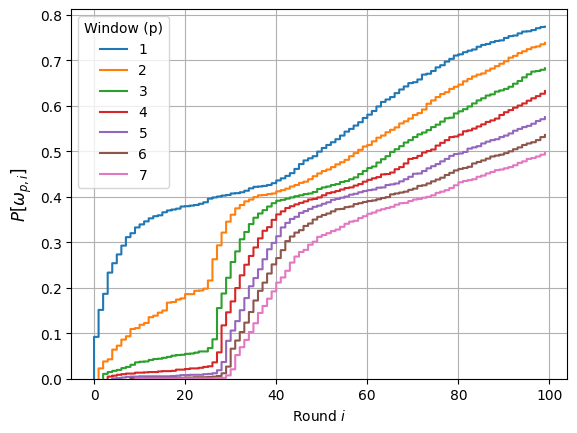

In [25]:
fig, ax = plt.subplots()
for window_size in range(1, 8):
    data = []
    for (env_id, trial), group in run_table.groupby(['env_id', 'trial']):
        valid_idx = group.cost.le(ltune_table.query(f'env_id == {env_id}').cost.values[0]) \
                         .rolling(window_size).min().fillna(0) \
                         .to_numpy().nonzero()[0]
        data.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
    ax.ecdf(data, label=f"{window_size}", complementary=False)
    
ax.set_xlabel("Round $i$")
ax.set_ylabel("$P[\omega_{p,i}]$", size=12)
ax.grid()
ax.legend(title="Window (p)")
plt.show()

In [26]:
# window_size = 1
# window_values = run_table.groupby(['env_id', 'trial']).cost.apply(
#     lambda x: (x.le(ltune_table.query(f'env_id == {x.name[0]}').cost.values[0])
#                .rolling(window_size) # Calculate over a rolling window size
#                .min().fillna(0) # Find all sequences in `window_size` that is all True (cost < cost_ltune)
#                .argmax())       # argmax to find the first index that satisfies window size
# ).replace(0, float('inf'))
# data = window_values.values